# Installation instructions

## Using conda

We recommend using [conda](https://docs.conda.io/en/latest/) for installing pySCTransform.

```bash
conda create -n pysct louvain scanpy jupyterlab
conda activate pysct
pip install git+https://github.com/saketkc/pysctransform.git
```

If you would like to use [glmGamPoi](https://bioconductor.org/packages/release/bioc/html/glmGamPoi.html) for estimation, `rpy2` and `glmGamPoi` need to be installed as well:

```bash
conda create -n pysct louvain scanpy jupyterlab rpy2 bioconductor-glmgampoi
conda activate pysct
pip install git+https://github.com/saketkc/pysctransform.git

```

## Using pip/venv

If you do not want to install conda, you can install using [venv]():

```bash
python3 -m venv pysct_venv
source pysct_venv/bin/activate
pip install scanpy louvain
pip install git+https://github.com/saketkc/pysctransform.git
```


In [1]:
%pylab inline
import scanpy as sc
import pandas as pd
from pysctransform import vst, get_hvg_residuals, SCTransform
from pysctransform.plotting import plot_fit, plot_residual_var, compare_with_sct
np.random.seed(42)

Populating the interactive namespace from numpy and matplotlib


In [2]:
pbmc3k = sc.read_h5ad("./pysct_test_data/pbmc3k.h5ad")

# Quickstart

We will use regularized NB GLM to calculate pearson residuals for [PMBC3k](https://support.10xgenomics.com/single-cell-gene-expression/datasets) dataset. Performing variance stabilization and feature selection are combined in one method
`SCTransform`.

`SCTransform` by default calls the `vst` method which uses `theta_ml` for ML estimation of $\theta$ (this does not require R/rpy2).


In [3]:
pbmc3k = sc.read_h5ad("./pysct_test_data/pbmc3k.h5ad")

# Get pearson residuals for 3K highly variable genes
residuals = SCTransform(pbmc3k, var_features_n=3000)
pbmc3k.obsm["pearson_residuals"] = residuals

# Peform PCA on pearson residuals
pbmc3k.obsm["X_pca"] = sc.pp.pca(pbmc3k.obsm["pearson_residuals"])

# Clustering and visualization
sc.pp.neighbors(pbmc3k, use_rep="X_pca")
sc.tl.umap(pbmc3k, min_dist=0.3)
sc.tl.louvain(pbmc3k)

## Compare with log normalization

In [4]:
adata = sc.read_h5ad("./pysct_test_data/pbmc3k.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.louvain(adata)

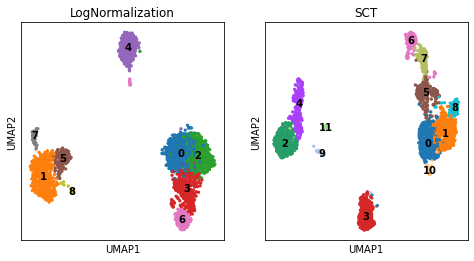

In [5]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

_ = sc.pl.umap(adata, color=["louvain"], legend_loc="on data", ax=ax1, show=False)
_ = sc.pl.umap(pbmc3k, color=["louvain"], legend_loc="on data", ax=ax2, show=False)


_ = ax1.set_title("LogNormalization")
_ = ax2.set_title("SCT")
#fig.tight_layout()
#fig


## Plot model characteristics

`SCTransform` function only returns the hvg residuals. Internally, it calls the `vst` function, which in turn
returns the GLM model parameters which we visualize below.



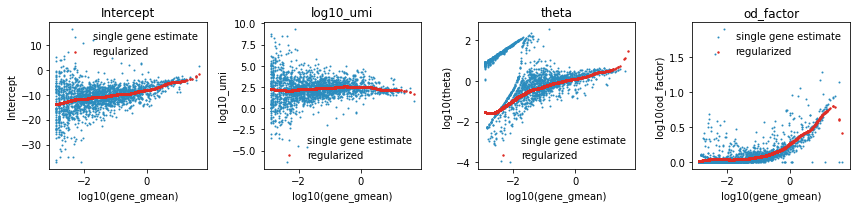

In [6]:
# Input to vst function is gene x cell sparse matrix
# method='theta_ml' requires only Python
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="theta_ml"
)
_ = plot_fit(vst_out_3k)


## Compare with SCTransform (R)

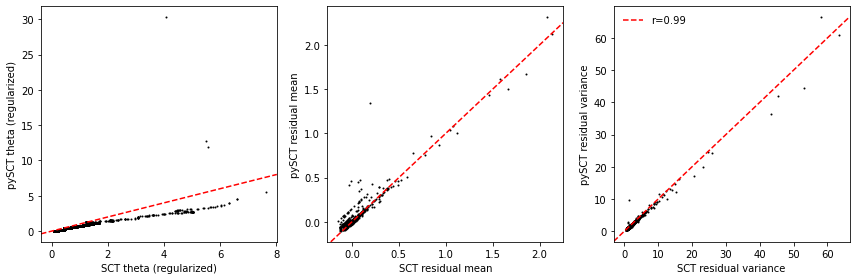

In [7]:
_ = compare_with_sct(
    vst_out_3k,
    sct_modelparsfit_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
    sct_geneattr_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_gene_attr.csv",
)

## Using glmGamPoi

There are multiple methods supported for estimating $\theta$ in pySCTransform. Invoking `method='theta_ml` only requires Python3 to run, while `method="glmgp"` or `method="glmgp_offset"` requires [rpy2](https://pypi.org/project/rpy2/) and 
[glmGamPoi](https://bioconductor.org/packages/release/bioc/html/glmGamPoi.html).



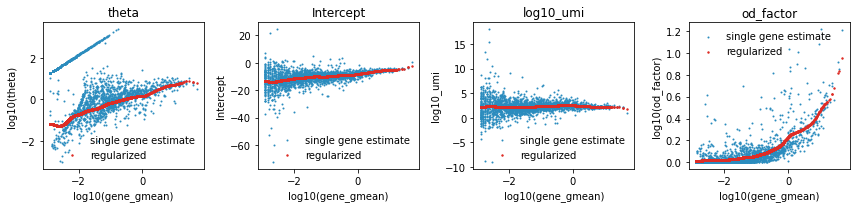

In [8]:
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="glmgp",
    n_cells=None,
    n_genes=2000,
)
_ = plot_fit(vst_out_3k)


We can also plot the final residual variances with respect to mean and highlight highly variable genes:



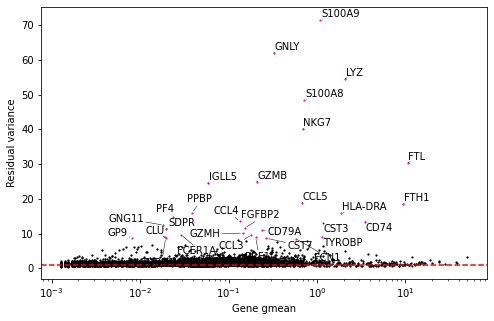

In [9]:
_ = plot_residual_var(vst_out_3k)

## Using v2 regularization

In v2 regularization, only intercept and $\theta$ are estimated while the slope is fixed. It also excludes poisson genes
from regularization step, with their final intercept calculated using the analytical form given by [Lause et al., 2021](https://www.biorxiv.org/content/10.1101/2020.12.01.405886v2).

This currently requires `rpy2` and `glmGamPoi` to be installed and can be invoked using `SCTransform()` method with `vst_flavor='v2'`.



len poisson genes 3855


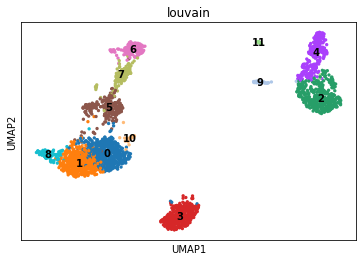

In [10]:
pbmc3k = sc.read_h5ad("./pysct_test_data/pbmc3k.h5ad")

# Get pearson residuals for 3K highly variable genes
residuals = SCTransform(pbmc3k, vst_flavor="v2")
pbmc3k.obsm["pearson_residuals"] = residuals

# Peform PCA on pearson residuals
pbmc3k.obsm["X_pca"] = sc.pp.pca(pbmc3k.obsm["pearson_residuals"])

# Clustering and visualization
sc.pp.neighbors(pbmc3k, use_rep="X_pca")
sc.tl.umap(pbmc3k, min_dist=0.3)
sc.tl.louvain(pbmc3k)
sc.pl.umap(pbmc3k, color=["louvain"], legend_loc="on data", show=True)


Visualize the parameters:

len poisson genes 3855


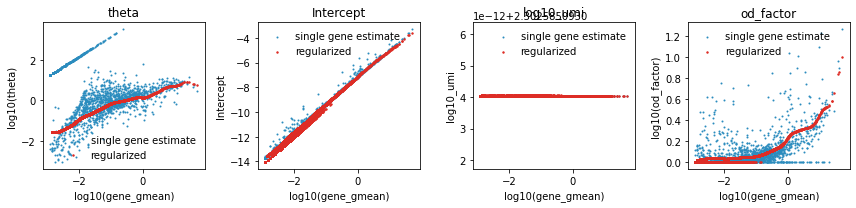

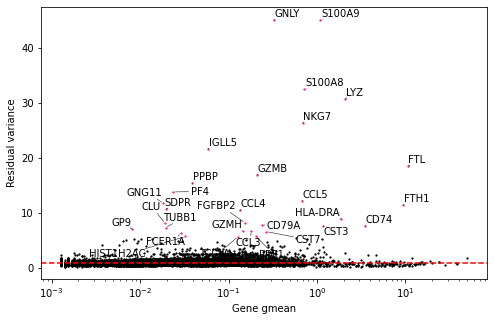

In [11]:
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="fix-slope",
    exclude_poisson=True
)
_ = plot_fit(vst_out_3k)
_ = plot_residual_var(vst_out_3k)